### Условие задачи

Разработка модели предсказания потери почтовых отправлений.

### Описание входных значений

train.csv — файл, содержащий данные о посылках, включая статус отправления

1 - операция, на которой цифровой след оборвался, т.к.
отправление потеряно
0 - отправление было вручено или возвращено
отправителю


test.csv — файл, содержащий данные о посылках для предсказания

sample_solution.csv — пример файла для отправки

### Функции

In [1]:
def df_info(data):
    display(data.info(verbose=True, show_counts=True))
    display(data.head())

In [2]:
# функция для вывода матрицы корреляций\
def corr_heatmap(data, title):
    data.corr()
    plt.figure(figsize=(18,10))
    sns.set(font_scale=1.1)
    sns.heatmap(data.corr(), annot=True, square=True, cmap="PuBuGn", fmt='.2f')\
    .set_title(title)
    plt.show()

In [3]:
def df_countplot(data, x, hue):
    plt.figure(figsize=(15,5))
    sns.countplot(x=x, hue = hue,data = data)
    plt.show()

In [4]:
def hist(data, col):
    data[col].hist(figsize=(15,5))
    plt.show()

In [5]:
def boxplot(x):
    plt.figure(figsize=(15,5))
    sns.boxplot(x=x)
    plt.show()

In [6]:
def uniq(col):
    print('df_train', df_train[col].nunique())
    print('df_test', df_test[col].nunique())    

In [7]:
def val(col):
    print('df_train')
    print(df_train[col].value_counts())
    print('df_test')
    print(df_test[col].value_counts())   

###  Библиотеки

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from datetime import datetime

%matplotlib inline

#отлючаем уведомления от Pandas
import warnings
warnings.filterwarnings('ignore')

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

### Загрузка датасетов

In [10]:
df_train = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv("test_dataset_test.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

In [11]:
df_train_1 = df_train[df_train['label']==1]
df_train_0 = df_train[df_train['label']==0]

### Знакомство с данными

In [12]:
df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             6000000 non-null  int64  
 1   oper_type + oper_attr          6000000 non-null  object 
 2   index_oper                     6000000 non-null  object 
 3   type                           6000000 non-null  object 
 4   priority                       6000000 non-null  float64
 5   is_privatecategory             6000000 non-null  object 
 6   class                          6000000 non-null  float64
 7   is_in_yandex                   6000000 non-null  object 
 8   is_return                      6000000 non-null  object 
 9   weight                         6000000 non-null  float64
 10  mailtype                       6000000 non-null  float64
 11  mailctg                        6000000 non-null  float64
 12  mailrank      

None

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [13]:
df_info(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             4000000 non-null  int64  
 1   oper_type + oper_attr          4000000 non-null  object 
 2   index_oper                     4000000 non-null  object 
 3   type                           4000000 non-null  object 
 4   priority                       4000000 non-null  float64
 5   is_privatecategory             4000000 non-null  object 
 6   class                          4000000 non-null  float64
 7   is_in_yandex                   4000000 non-null  object 
 8   is_return                      4000000 non-null  object 
 9   weight                         4000000 non-null  float64
 10  mailtype                       4000000 non-null  float64
 11  mailctg                        4000000 non-null  float64
 12  mailrank      

None

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0


In [14]:
df_info(df_sample_solution)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   id      4000000 non-null  int64
 1   label   4000000 non-null  int64
dtypes: int64(2)
memory usage: 61.0 MB


None

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0


В данных нет пропусков. По остальному пока не ясно.

### Исследуем баланс классов

In [15]:
# распределение классов по целевому признаку
df_train['label'].value_counts(normalize='bool')

0    0.971503
1    0.028497
Name: label, dtype: float64

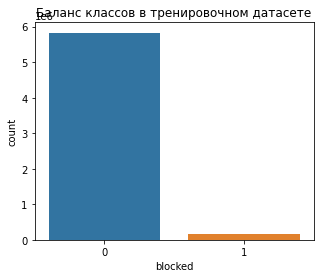

In [16]:
plt.figure(figsize=(5,4))
sns.countplot(data=df_train, x="label")
plt.title('Баланс классов в тренировочном датасете')
plt.xlabel('blocked')
plt.ylabel('count')
plt.show()

Классы несбалансированы по целевому признаку. 3% посылок потеряны.

### Исследовательский анализ данных

In [17]:
df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             6000000 non-null  int64  
 1   oper_type + oper_attr          6000000 non-null  object 
 2   index_oper                     6000000 non-null  object 
 3   type                           6000000 non-null  object 
 4   priority                       6000000 non-null  float64
 5   is_privatecategory             6000000 non-null  object 
 6   class                          6000000 non-null  float64
 7   is_in_yandex                   6000000 non-null  object 
 8   is_return                      6000000 non-null  object 
 9   weight                         6000000 non-null  float64
 10  mailtype                       6000000 non-null  float64
 11  mailctg                        6000000 non-null  float64
 12  mailrank      

None

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


#### Размерность

In [18]:
uniq('id')

df_train 6000000
df_test 4000000


In [19]:
df_sample_solution.id.nunique()

4000000

Каждая строка в датасетах уникальна.

## Исследование признаков

#### oper_type + oper_attr Тип и атрибут операции

In [20]:
uniq('oper_type + oper_attr')

df_train 109
df_test 102


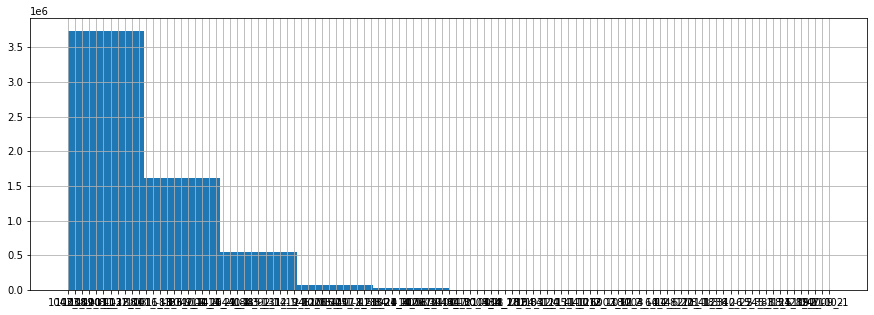

oper_type + oper_attr
2_11            1
8_21            1
34_-1           1
14_1002         1
2_10            1
            ...  
1_-1       359402
8_0        402877
1019_-1    413710
1022_-1    656597
1020_-1    693154
Name: id, Length: 109, dtype: int64

In [21]:
hist(df_train, 'oper_type + oper_attr')
df_train.groupby(['oper_type + oper_attr'])['id'].count().sort_values()

#### index_oper Индекс места операции


In [22]:
uniq('index_oper')

df_train 38661
df_test 35589


In [23]:
df_train['index_oper'].nunique()

38661

In [24]:
df_test['index_oper'].nunique()

35589

Признак не показал себя полезным при тестировании моделей.

#### type Обозначение типа объекта почтовой связи

In [25]:
val('type')

df_train
Цех               2093668
ММПО              1614974
Участок            926631
ГОПС               463750
ТИ                 305490
П                  245814
МСЦ                223241
СОПС                72161
СЦ                  12469
ОП                   9527
МСО                  7465
ОПП                  7190
АОПП                 6682
МРП                  3850
0                    3444
АО                   1304
ПЕРЕДВИЖНОЕ ОС       1006
ППС                   682
УМСЦ                  569
УКД                    83
Name: type, dtype: int64
df_test
Цех               1395154
ММПО              1075996
Участок            619027
ГОПС               308878
ТИ                 203015
П                  164467
МСЦ                149374
СОПС                48117
СЦ                   8310
ОП                   6441
МСО                  5117
АОПП                 4532
ОПП                  4463
МРП                  2520
0                    2249
АО                    807
ПЕРЕДВИЖНОЕ ОС        

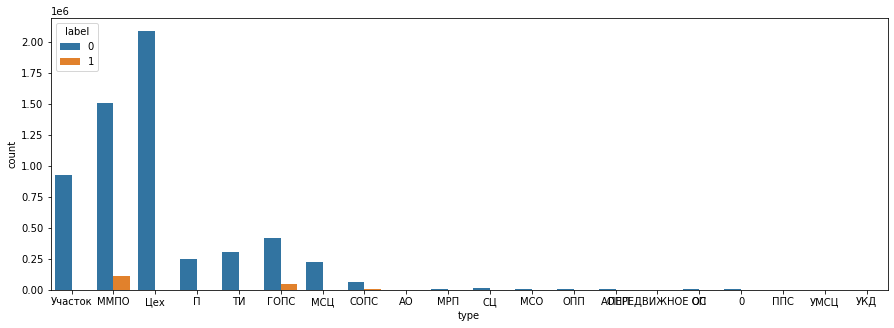

label,0,1
type,,
0,3381.0,63.0
АО,980.0,324.0
АОПП,6682.0,NaN
ГОПС,414892.0,48858.0
ММПО,1505634.0,109340.0
МРП,3850.0,NaN
МСО,7462.0,3.0
МСЦ,223208.0,33.0
ОП,9526.0,1.0


In [26]:
df_countplot(df_train, 'type', 'label')
df_train.pivot_table(index='type', columns='label', values='id', aggfunc='count')

#### priority Приоритет объекта


In [27]:
uniq('priority')

df_train 4
df_test 4


In [28]:
val('priority')

df_train
7503.0    3990518
7506.0    1744627
7504.0     261583
0.0          3272
Name: priority, dtype: int64
df_test
7503.0    2660834
7506.0    1162848
7504.0     174225
0.0          2093
Name: priority, dtype: int64


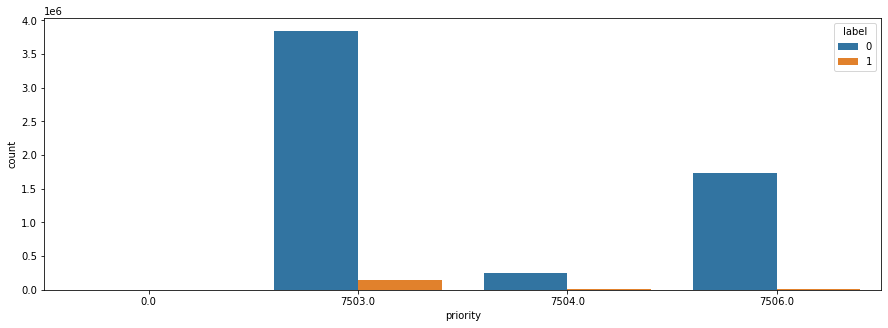

label,0,1
priority,,
0.0,3272.0,NaN
7503.0,3842757.0,147761.0
7504.0,245740.0,15843.0
7506.0,1737251.0,7376.0


In [29]:
df_countplot(df_train, 'priority', 'label')
df_train.pivot_table(index='priority', columns='label', values='id', aggfunc='count')

Потерянные посылки в тренировочном датасете всегда имеют указанный приоритет. Удалим строки, для которых приоритет не указан (возможно в силу технической ошибки) и переведем в категориальный признак.

In [30]:
df_train = df_train[df_train['priority']!=0]

In [31]:
df_train[df_train['priority']!=0].pivot_table(index='priority', columns='label', values='id', aggfunc='count')

label,0,1
priority,,
7503.0,3842757,147761
7504.0,245740,15843
7506.0,1737251,7376


Переведем в категориальный признак.

In [32]:
df_train["priority"] = pd.Categorical(df_train["priority"])
df_train["priority"].astype('category').cat.codes
df_train["priority"] = df_train["priority"].cat.codes

In [33]:
df_test["priority"] = pd.Categorical(df_test["priority"])
df_test["priority"].astype('category').cat.codes
df_test["priority"] = df_test["priority"].cat.codes

#### is_privatecategory  является ли отделением закрытого типа


In [34]:
val('is_privatecategory')

df_train
N    5993922
Y       2806
Name: is_privatecategory, dtype: int64
df_test
N    3996480
Y       1820
0       1700
Name: is_privatecategory, dtype: int64


In [35]:
df_train.pivot_table(index='is_privatecategory', columns='label', values='id', aggfunc='count')

label,0,1
is_privatecategory,,
N,5823227,170695
Y,2521,285


Признак не зарекомендовал себя при тестировании модели.

#### class Значение класса или категории объекта почтовой связи


In [36]:
val('class')

df_train
0.0    5211573
3.0     371753
2.0     150393
4.0     131468
1.0     114117
5.0      17424
Name: class, dtype: int64
df_test
0.0    3476329
3.0     248562
2.0     100242
4.0      87307
1.0      76204
5.0      11356
Name: class, dtype: int64


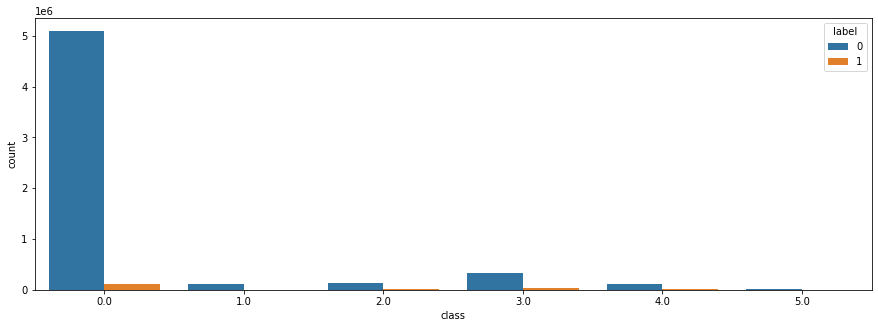

label,0,1
class,,
0.0,5098782,112791
1.0,112998,1119
2.0,143112,7281
3.0,337649,34104
4.0,117969,13499
5.0,15238,2186


In [37]:
df_countplot(df_train, 'class', 'label')
df_train.pivot_table(index='class', columns='label', values='id', aggfunc='count')

#### is_in_yandex адрес отделения связи отображается в Яндекс-картах

In [38]:
val('is_in_yandex')

df_train
N    3585354
Y    2411374
Name: is_in_yandex, dtype: int64
df_test
N    2389898
Y    1608402
0       1700
Name: is_in_yandex, dtype: int64


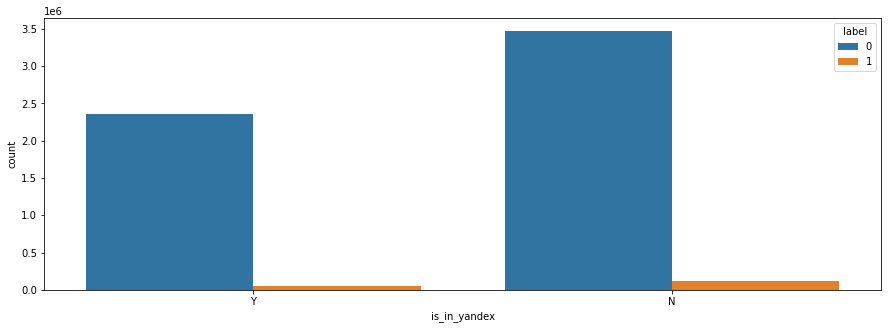

label,0,1
is_in_yandex,,
N,3470894,114460
Y,2354854,56520


In [39]:
df_countplot(df_train, 'is_in_yandex', 'label')
df_train.pivot_table(index='is_in_yandex', columns='label', values='id', aggfunc='count')

Признак не зарекомендовал себя при тестировании модели.

#### is_return Отправление движется в направлении возврата отправителю

In [40]:
val('is_return')

df_train
N    5989747
Y       6981
Name: is_return, dtype: int64
df_test
N    3995443
Y       4557
Name: is_return, dtype: int64


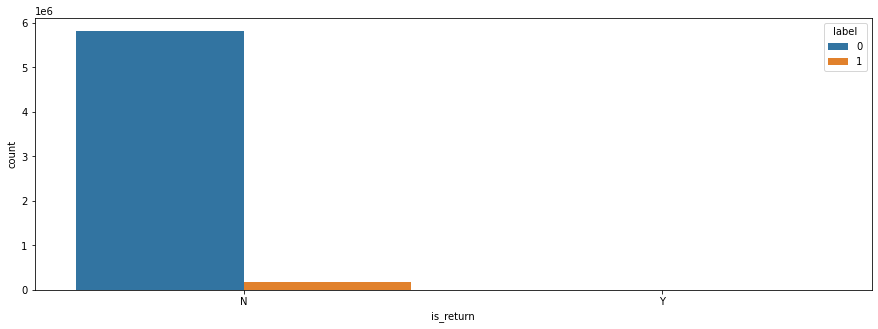

label,0,1
is_return,,
N,5818922,170825
Y,6826,155


In [41]:
df_countplot(df_train, 'is_return', 'label')
df_train.pivot_table(index='is_return', columns='label', values='id', aggfunc='count')

Большая часть утерянных посылок не двигалась в обратном направлени. Вероятнее всего, признак бесполезен.

#### weight Вес в граммах

In [42]:
uniq('weight')

df_train 2809
df_test 2804


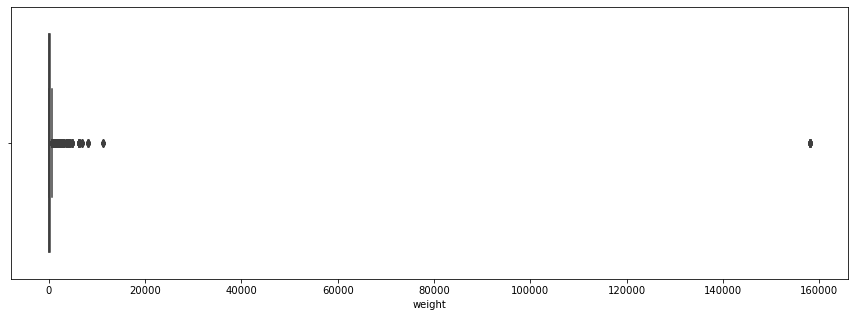

In [43]:
boxplot(df_train['weight'])

In [44]:
a0 = np.percentile(df_train['weight'], [97])
a0[0]

1246.0

In [45]:
df_train = df_train[df_train['weight'] <=a0[0]]
len(df_train)

5816938

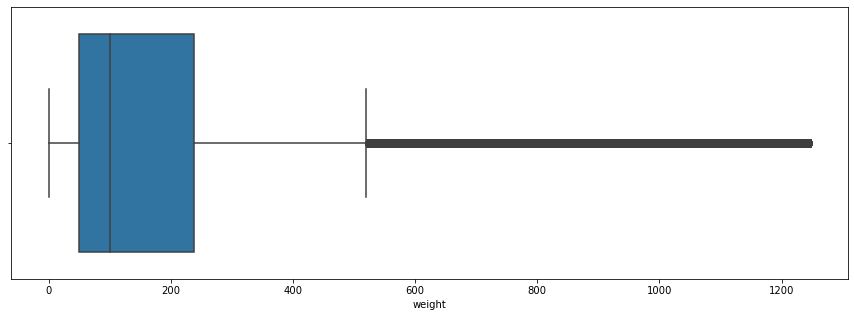

In [46]:
boxplot(df_train['weight'])

Проверим были ли посылки с нулевым весом.

In [47]:
df_train[df_train['weight']==0].id.nunique()

4893

4893 посылки имели нулевой вес. Вес самого маленького пустого конверта составляет 5 грамм, однако наверняка в нем еще что-то лежит. Поэтому отсечем ве записи со значением веса посылки меньше 10 граммов.

In [48]:
df_train[(df_train['weight']<10)&(df_train['label']==1)].id.nunique()

7132

In [49]:
df_train = df_train[df_train['weight']>=10]
len(df_train)

5716032

#### mailtype Код вида отправления

In [50]:
val('mailtype')

df_train
5.0    5709723
0.0       4609
2.0       1329
7.0        310
1.0         20
8.0         19
4.0         18
6.0          2
9.0          2
Name: mailtype, dtype: int64
df_test
5.0    3995167
0.0       3453
2.0        969
7.0        336
4.0         47
8.0         14
1.0         14
Name: mailtype, dtype: int64


In [51]:
df_train.pivot_table(index='mailtype', columns='label', values='id', aggfunc='count')

label,0,1
mailtype,,
0.0,4606.0,3.0
1.0,20.0,NaN
2.0,1304.0,25.0
4.0,16.0,2.0
5.0,5548479.0,161244.0
6.0,2.0,NaN
7.0,305.0,5.0
8.0,19.0,NaN
9.0,2.0,NaN


#### mailctg Код категории почтового отправления

In [52]:
val('mailctg')

df_train
 1.0    4485029
 0.0    1178029
-1.0      52626
 3.0        328
 5.0         20
Name: mailctg, dtype: int64
df_test
 1.0    3127158
 0.0     836708
-1.0      35737
 3.0        383
 5.0         14
Name: mailctg, dtype: int64


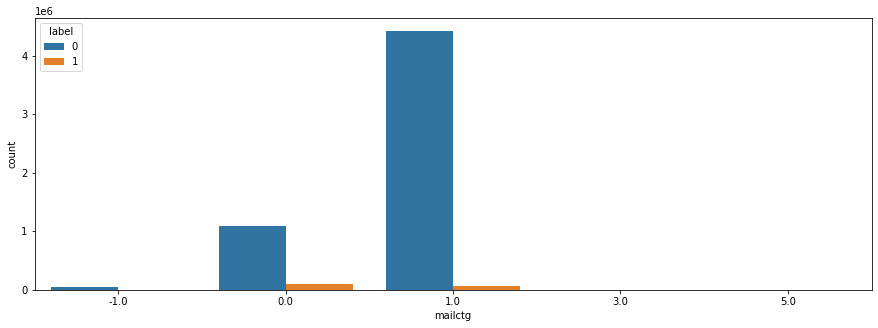

label,0,1
mailctg,,
-1.0,51493.0,1133.0
0.0,1081710.0,96319.0
1.0,4421209.0,63820.0
3.0,321.0,7.0
5.0,20.0,NaN


In [53]:
df_countplot(df_train, 'mailctg', 'label')
df_train.pivot_table(index='mailctg', columns='label', values='id', aggfunc='count')

#### mailrank Код разряда почтового отправления

In [54]:
val('mailrank')

df_train
0.0    5716032
Name: mailrank, dtype: int64
df_test
0.0    4000000
Name: mailrank, dtype: int64


Признак имеет одно значение - можно удалять, нет смысла ипользовать для обучения.

#### directctg Код классификации отправления

In [55]:
val('directctg')

df_train
2.0    5650593
1.0      65439
Name: directctg, dtype: int64
df_test
2.0    3953723
1.0      46171
0.0        106
Name: directctg, dtype: int64


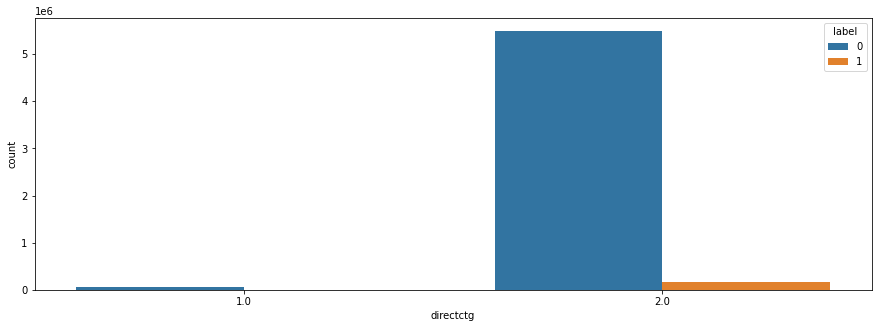

In [56]:
df_countplot(df_train, 'directctg', 'label')

In [57]:
df_train.pivot_table(index='directctg', columns='label', values='id', aggfunc='count')

label,0,1
directctg,,
1.0,64241,1198
2.0,5490512,160081


Признак безполезен.

#### transport_pay Общая сумма платы за пересылку в условной валюте


In [58]:
uniq('transport_pay')

df_train 7325
df_test 10358


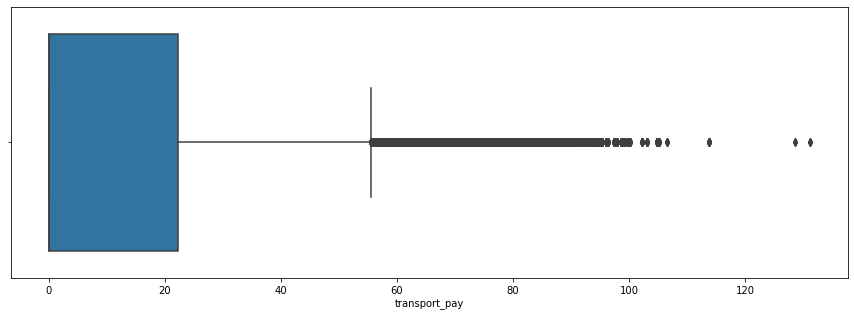

In [59]:
boxplot(df_train['transport_pay'])

In [60]:
a1 = np.percentile(df_train['transport_pay'], [97])
a1[0]

56.29

In [61]:
df_train = df_train[df_train['transport_pay'] <= a1[0]]
len(df_train)

5544678

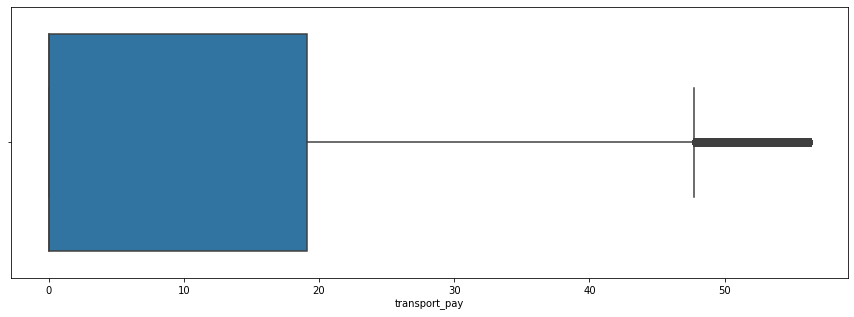

In [62]:
boxplot(df_train['transport_pay'])

#### postmark Код отметки

In [63]:
val('postmark')

df_train
0.0       5543906
512.0         682
1024.0         79
256.0           7
1.0             4
Name: postmark, dtype: int64
df_test
0.0       3999288
512.0         622
1024.0         67
8.0            15
256.0           4
1.0             4
Name: postmark, dtype: int64


In [64]:
df_train.pivot_table(index='postmark', columns='label', values='id', aggfunc='count')

label,0,1
postmark,,
0.0,5384543.0,159363.0
1.0,4.0,NaN
256.0,7.0,NaN
512.0,671.0,11.0
1024.0,77.0,2.0


Признак безполезен.

#### name_mfi Наименование вложений (указано через запятую),указывается на бирке отправления

In [65]:
uniq('name_mfi')

df_train 203622
df_test 205458


In [66]:
df_train['name_mfi'] = df_train['name_mfi'].str.lower()
df_test['name_mfi'] = df_test['name_mfi'].str.lower()

#### Число наименований в посылке

In [67]:
df_train['mfi_name_count'] = df_train.name_mfi.str.count(',')
df_test['mfi_name_count'] = df_test.name_mfi.str.count(',')

df_train['mfi_name_count'] = np.where(df_train['name_mfi']=='0', 0, df_train['mfi_name_count']+1)
df_test['mfi_name_count'] = np.where(df_test['name_mfi']=='0', 0, df_test['mfi_name_count']+1)

In [68]:
df_train[['name_mfi', 'mfi_name_count']].head()

,name_mfi,mfi_name_count
0,"fishhook,usb",2
1,"screen protector,case(q613b),case(208b40-db)",3
2,"pendant necklaces,rings for women,necklaces",3
3,motorcycle signal lamp,1
4,backpack,1


#### weight_mfi Суммарная масса вложений


In [69]:
uniq('weight_mfi')

df_train 1676
df_test 2069


In [70]:
df_test['weight_mfi'].nunique()

2069

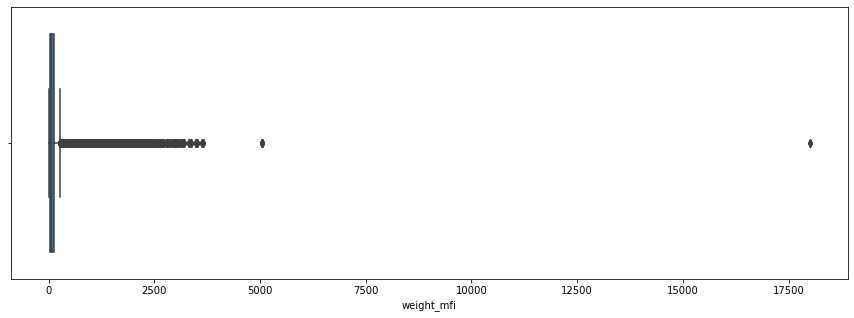

In [71]:
boxplot(df_train['weight_mfi'])

In [72]:
a2 = np.percentile(df_train['weight_mfi'], [97])
a2[0]

542.0

In [73]:
df_train = df_train[df_train['weight_mfi'] <= a2[0]]
len(df_train)

5378411

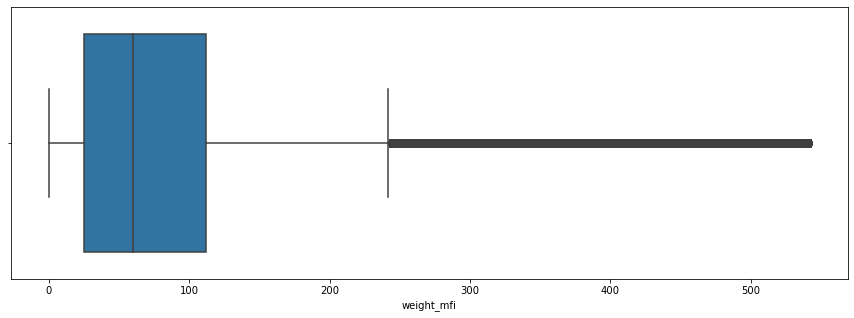

In [74]:
boxplot(df_train['weight_mfi'])

Проверим были ли посылки с нулевым суммарным весом вложений.

In [75]:
df_train[df_train['weight_mfi']==0].id.nunique()

662206

In [76]:
df_test[df_test['weight_mfi']==0].id.nunique()

545468

In [77]:
df_train[(df_train['weight_mfi']==0)&(df_train['label']==1)].id.nunique()

10717

In [78]:
df_train[df_train['weight_mfi']<10].pivot_table(index='weight_mfi', columns='label', values='id', aggfunc='count')

label,0,1
weight_mfi,,
0.0,651489,10717
1.0,3875,57
2.0,3677,62
3.0,4054,69
4.0,4832,111
5.0,9241,294
6.0,7655,222
7.0,8753,232
8.0,13103,328


10731 потерянная посылка имела нулевой вес. Отсечем здесь тоже по 10 граммам.

In [79]:
df_train = df_train[df_train['weight_mfi']>=10]
len(df_train)

4638544

#### price_mfi Суммарная стоимость вложений в условной валюте

In [80]:
uniq('price_mfi')

df_train 3819
df_test 6529


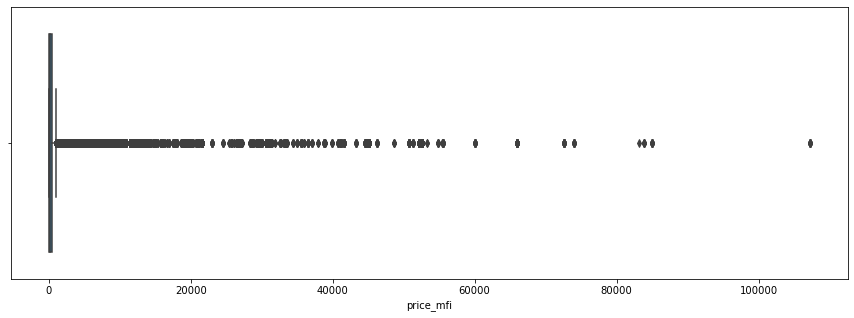

In [81]:
boxplot(df_train['price_mfi'])

In [82]:
a3 = np.percentile(df_train['price_mfi'], [97])
a3[0]

1375.0

In [83]:
df_train = df_train[df_train['price_mfi'] <= a3[0]]
len(df_train)

4499549

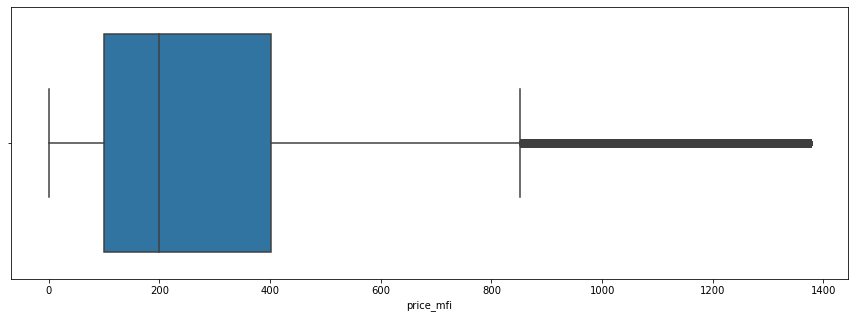

In [84]:
boxplot(df_train['price_mfi'])

Проверим были ли посылки с нулевой стоимостью доставки.

In [85]:
df_train[df_train['price_mfi']==0].id.nunique()

205

In [86]:
a3 = np.percentile(df_train['price_mfi'], [2])
a3[0]

10.0

In [87]:
df_train[df_train['price_mfi']<10].pivot_table(index='price_mfi', columns='label', values='id', aggfunc='count')

label,0,1
price_mfi,,
0.0,202,3
1.0,17240,751
2.0,13262,665
3.0,3879,176
4.0,3312,139
5.0,6201,308
6.0,2047,100
7.0,1710,81
8.0,3166,119


In [88]:
df_train = df_train[df_train['price_mfi']>=10]
len(df_train)

4444641

#### dist_qty_oper_login_1 Количество уникальных имен операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора


In [89]:
uniq('dist_qty_oper_login_1')

df_train 154
df_test 164


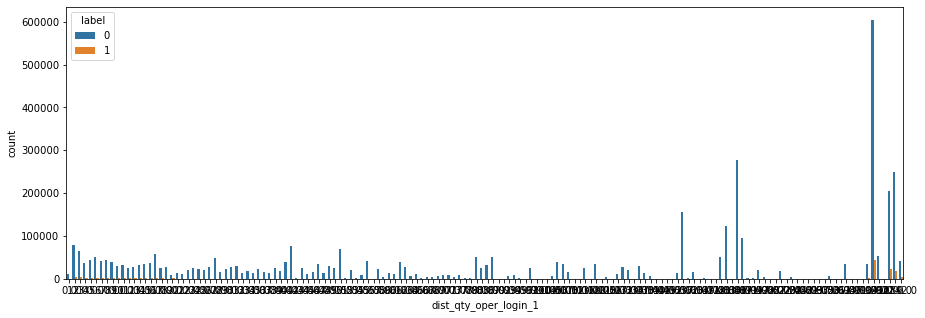

In [90]:
df_countplot(df_train, 'dist_qty_oper_login_1', 'label')

#### total_qty_oper_login_1 Количество отправлений с уникальным именем операторов,
задействованных в обработке
данного типа отправлений
(mailtype) на конкретном индексе,
по которым возможно
идентифицировать оператора

In [91]:
uniq('total_qty_oper_login_1')

df_train 17826
df_test 18268


#### total_qty_oper_login_0  Количество отправлений данного типа (mailtype), 
которые были
обработаны неизвестным
оператором на этом индексе

In [92]:
uniq('total_qty_oper_login_0')

df_train 9118
df_test 9319


#### total_qty_over_index_and_type Общее количество отправлений данного типа (mailtype), прошедших обработку на этом индексе

In [93]:
uniq('total_qty_over_index_and_type')

df_train 19503
df_test 19977


#### is_wrong_sndr_name Есть ли явные признаки, что имя отправителя введено некорректно?

In [94]:
val('is_wrong_sndr_name')

df_train
0    4442236
1       2405
Name: is_wrong_sndr_name, dtype: int64
df_test
0    3989669
1      10331
Name: is_wrong_sndr_name, dtype: int64


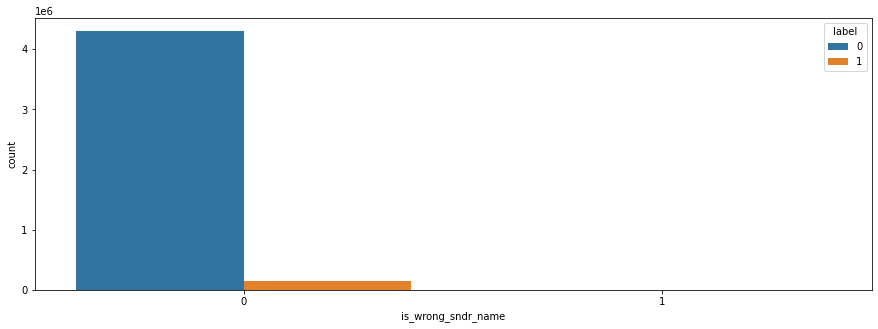

label,0,1
is_wrong_sndr_name,,
0,4302503,139733
1,2140,265


In [95]:
df_countplot(df_train, 'is_wrong_sndr_name', 'label')
df_train.pivot_table(index='is_wrong_sndr_name', columns='label', values='id', aggfunc='count')

Признак выглядит бесполезным.

#### is_wrong_rcpn_name Есть ли явные признаки, что имя получателя введено некорректно?

In [96]:
val('is_wrong_sndr_name')

df_train
0    4442236
1       2405
Name: is_wrong_sndr_name, dtype: int64
df_test
0    3989669
1      10331
Name: is_wrong_sndr_name, dtype: int64


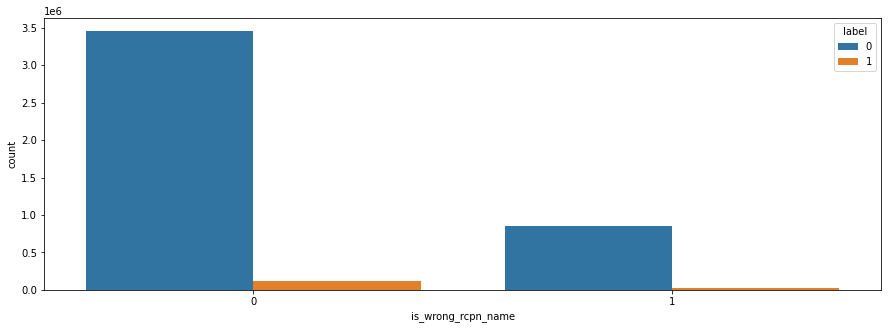

label,0,1
is_wrong_rcpn_name,,
0,3455291,114684
1,849352,25314


In [97]:
df_countplot(df_train, 'is_wrong_rcpn_name', 'label')
df_train.pivot_table(index='is_wrong_rcpn_name', columns='label', values='id', aggfunc='count')

#### is_wrong_phone_number Есть ли явные признаки, что номер телефона получателя введен некорректно?


In [98]:
val('is_wrong_phone_number')

df_train
0    3600972
1     843669
Name: is_wrong_phone_number, dtype: int64
df_test
0    3317021
1     682979
Name: is_wrong_phone_number, dtype: int64


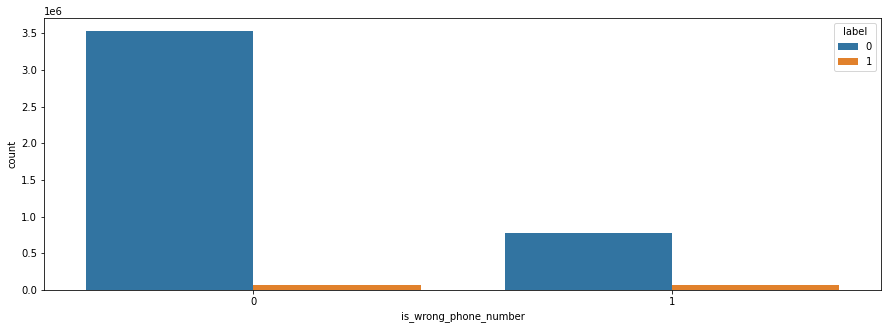

label,0,1
is_wrong_phone_number,,
0,3532107,68865
1,772536,71133


In [99]:
df_countplot(df_train, 'is_wrong_phone_number', 'label')
df_train.pivot_table(index='is_wrong_phone_number', columns='label', values='id', aggfunc='count')

#### is_wrong_address Есть ли явные признаки, что адрес получателя введен некорректно?

In [100]:
val('is_wrong_address')

df_train
0    4442948
1       1693
Name: is_wrong_address, dtype: int64
df_test
0    3995054
1       4946
Name: is_wrong_address, dtype: int64


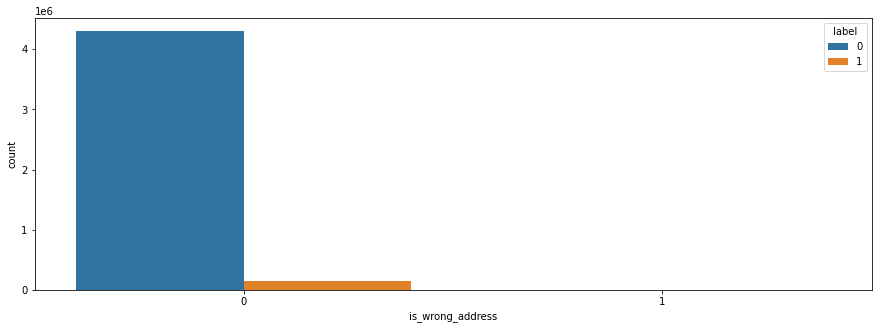

label,0,1
is_wrong_address,,
0,4303149,139799
1,1494,199


In [101]:
df_countplot(df_train, 'is_wrong_address', 'label')
df_train.pivot_table(index='is_wrong_address', columns='label', values='id', aggfunc='count')

Признак выглядит бесполезным.

### Удаление столбцов, мало влияющих на работу модели

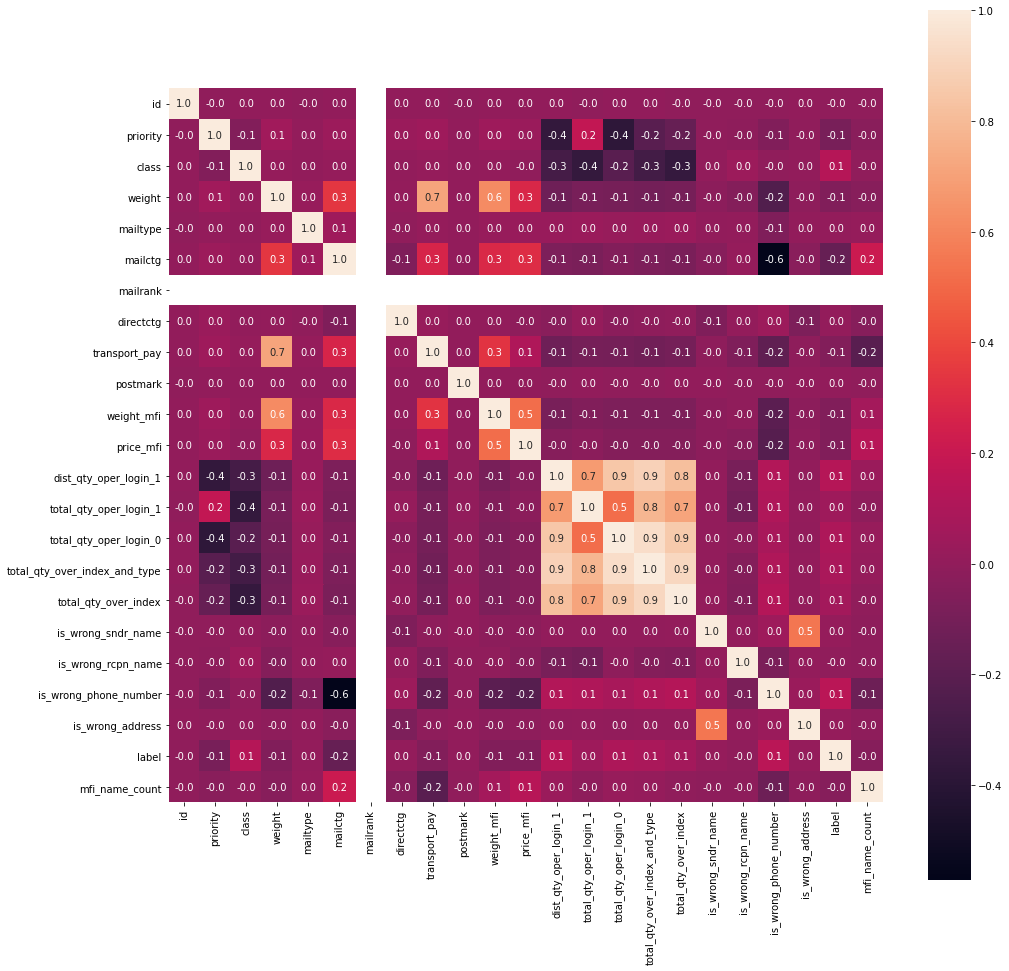

In [102]:
plt.rcParams['figure.figsize']=(16,16)

corr = df_train.iloc[:200000].corr()
g = sns.heatmap(corr, square = True, annot=True , fmt='.1f', annot_kws={'size':10})

Признаки 'total_qty_oper_login_1', 'total_qty_over_index_and_type','total_qty_over_index', 'total_qty_oper_login_0' коррелируют между собой. оставила dist_qty_oper_login_1.

In [103]:
cols_to_drop = ['total_qty_oper_login_1', 'total_qty_over_index_and_type',\
               'total_qty_over_index', 'total_qty_oper_login_0']
df_train = df_train[df_train.columns.drop(cols_to_drop)]
df_test = df_test[df_test.columns.drop(cols_to_drop)]

Также удалю столбцы:

* 'weight' - сильная корреляция 
* 'mailrank' - признак имеет одно значение
* 'index_oper', 'is_privatecategory', 'is_in_yandex', 'is_return', 'mailtype', 'directctg', 'postmark, 'is_wrong_sndr_name', 'is_wrong_address' - признаки слабо влияли на качество модели.
* 'priority', 'is_wrong_rcpn_name', 'is_wrong_phone_number', ', 'oper_type + oper_attr' - признаки слабо влияли на качество модели.

In [104]:
cols_to_drop = ['index_oper', 'is_privatecategory', 'is_in_yandex', 'is_return', 'weight', 'mailtype',\
               'mailrank', 'directctg', 'postmark', 'is_wrong_sndr_name', 'is_wrong_address',\
                'priority', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'oper_type + oper_attr']
df_train = df_train[df_train.columns.drop(cols_to_drop)]
df_test = df_test[df_test.columns.drop(cols_to_drop)]

### Типы данных

In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444641 entries, 0 to 5999999
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   type                   object 
 2   class                  float64
 3   mailctg                float64
 4   transport_pay          float64
 5   name_mfi               object 
 6   weight_mfi             float64
 7   price_mfi              float64
 8   dist_qty_oper_login_1  float64
 9   label                  int64  
 10  mfi_name_count         int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 406.9+ MB


### Проверка на мультиколлениарность

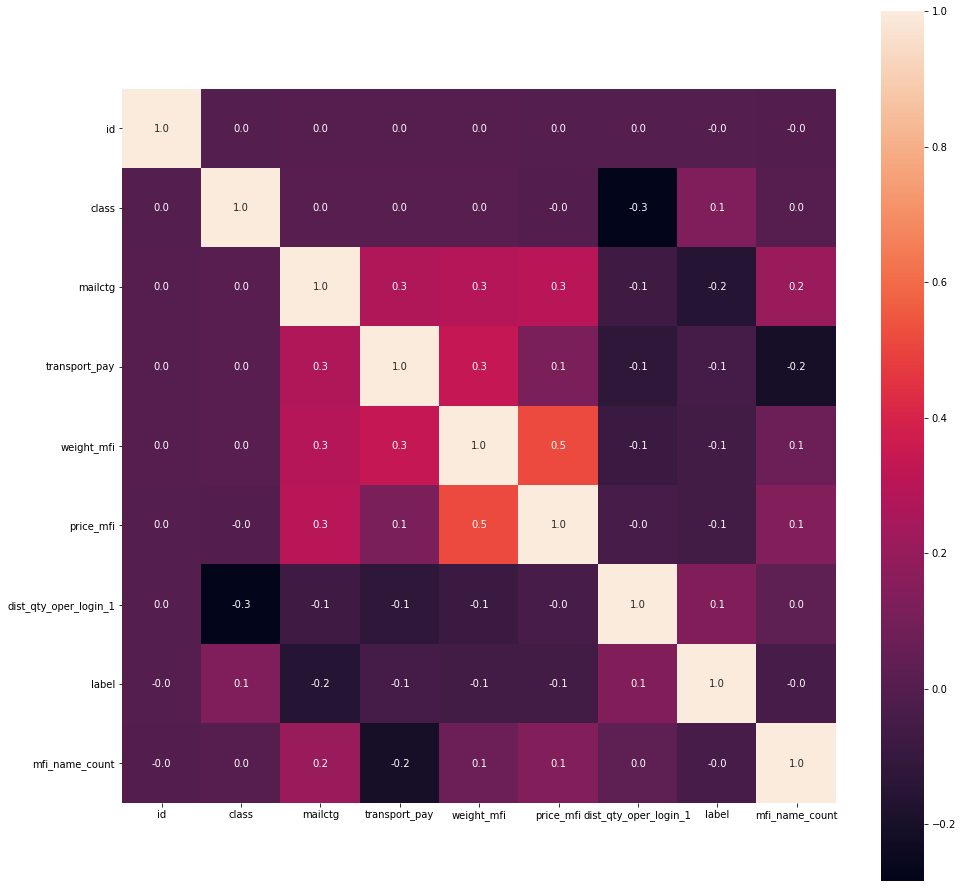

In [106]:
plt.rcParams['figure.figsize']=(16,16)

corr = df_train.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True , fmt='.1f', annot_kws={'size':10})

### Проверка датасетов на пропуски

In [107]:
df_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444641 entries, 0 to 5999999
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     4444641 non-null  int64  
 1   type                   4444641 non-null  object 
 2   class                  4444641 non-null  float64
 3   mailctg                4444641 non-null  float64
 4   transport_pay          4444641 non-null  float64
 5   name_mfi               4444641 non-null  object 
 6   weight_mfi             4444641 non-null  float64
 7   price_mfi              4444641 non-null  float64
 8   dist_qty_oper_login_1  4444641 non-null  float64
 9   label                  4444641 non-null  int64  
 10  mfi_name_count         4444641 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 406.9+ MB


In [108]:
df_test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     4000000 non-null  int64  
 1   type                   4000000 non-null  object 
 2   class                  4000000 non-null  float64
 3   mailctg                4000000 non-null  float64
 4   transport_pay          4000000 non-null  float64
 5   name_mfi               4000000 non-null  object 
 6   weight_mfi             4000000 non-null  float64
 7   price_mfi              4000000 non-null  float64
 8   dist_qty_oper_login_1  4000000 non-null  float64
 9   mfi_name_count         4000000 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 305.2+ MB


## ML

In [109]:
# созддим переменную под параметр random_state
rs = 42

In [110]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_train.drop(["id", "label", 'name_mfi'], axis = 1)
y = df_train[["label"]]

X_test = df_test.drop(["id", 'name_mfi'], axis = 1)

In [111]:
# Из обучающей выборки выделим валидационную выборку
X_train, X_val, y_train, y_val =\
train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

### CatBoostClassifier

In [112]:
cat_features = ['type'] 

In [113]:
# определение весов целевого класса 
from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_train['label']),
                                             df_train['label']))
cw

[0.5162612788098804, 15.873944627780396]

In [114]:
%%time
model = CatBoostClassifier(
    iterations=50,
    random_seed=rs,
    learning_rate=0.9,
    #early_stopping_rounds= 100,
    eval_metric='Recall',
    depth=14,
    class_weights = (cw[0], cw[1]), 
    cat_features= cat_features,
    loss_function='Logloss',
    leaf_estimation_method='Gradient',
    max_ctr_complexity=1
)

model.fit(X_train, y_train,
         eval_set=(X_val, y_val),
          verbose=10,
          plot=False
)

0:	learn: 0.9288748	test: 0.9282857	best: 0.9282857 (0)	total: 1.51s	remaining: 1m 13s
10:	learn: 0.9365036	test: 0.9372286	best: 0.9436571 (6)	total: 11.9s	remaining: 42.3s
20:	learn: 0.9400846	test: 0.9401429	best: 0.9436571 (6)	total: 22s	remaining: 30.4s
30:	learn: 0.9444561	test: 0.9436857	best: 0.9441429 (28)	total: 32.7s	remaining: 20s
40:	learn: 0.9470180	test: 0.9455429	best: 0.9457714 (34)	total: 43.6s	remaining: 9.57s
49:	learn: 0.9470657	test: 0.9449143	best: 0.9457714 (34)	total: 53.4s	remaining: 0us

bestTest = 0.9457714286
bestIteration = 34

Shrink model to first 35 iterations.
Wall time: 56.1 s


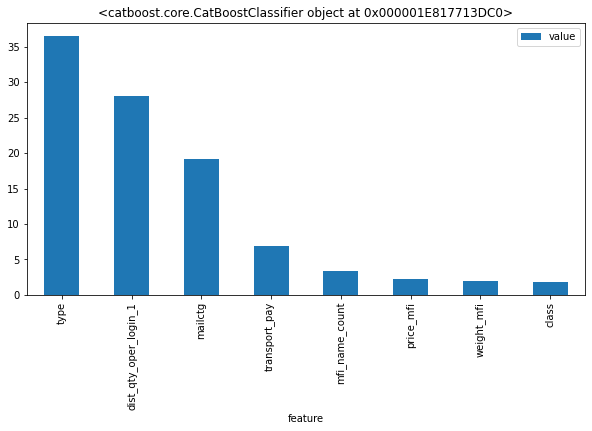

In [115]:
df_feature_importance = pd.DataFrame({'feature': X_train.columns.values, 'value': model.feature_importances_})
df_feature_importance = df_feature_importance.set_index(['feature'])
df_feature_importance = df_feature_importance.sort_values(by='value', ascending=False)
df_feature_importance.plot(kind = 'bar', title= model, figsize=(10,5))
plt.show()

In [116]:
pred = model.predict(X_test)

In [117]:
# все признаки
Sub = pd.DataFrame({'id':df_test['id'],'label': pred })

Sub.head()

,id,label
0,7815282,1
1,8443555,1
2,6352559,1
3,4921420,0
4,1420440,0


In [118]:
Sub['label'].value_counts()

0    3131403
1     868597
Name: label, dtype: int64

In [119]:
Sub.to_csv("final.csv", index=False, line_terminator='\r')